In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO

In [2]:

def theoretical_tryptic_peptides(seq, min_length):
    """
     This function generates the set of theoretical tryptic peptides (cuts at K and R) longer than a specified length for a given protein sequence 

     Parameters:
          - seq: Input protein sequence.
          - min_length: Minimum length requirement for tryptic peptides to be considered.

     Returns:
          - List of tryptic peptides from the protein sequence with lengths greater than or equal to minLength
     """
    to_split = seq.replace("K","K*").replace("R","R*")
    peptides = to_split.split("*")

    return [x for x in peptides if len(x) >= min_length]


In [3]:
"""
  This function generates all possible combinations of replacing one amino acid with another in a sequence
  Parameters:
     s: Input peptide sequence.
     aa1: First amino acid to be replaced.
     aa2: Second amino acid to replace the first.
  
  Returns:
    List of all possible combinations of the peptide sequence with amino acid replacements
"""

def generate_combinations(s,aa1,aa2):
    new_s_1 =s.replace(aa1,aa2)
    new_s_2 =s.replace(aa2,aa1)

    all_pos = []
    for i in range(len(s)):
        if s[i] == aa1 or s[i] == aa2:
            all_pos.extend([
                s[:i] + new_s_1[i:], s[:i] + new_s_2[i:],
                s[:i] + new_s_1[i] + new_s_2[i+1:], s[:i] + new_s_2[i] + new_s_1[i+1:]
            ])
    return list(set(all_pos))

In [4]:


def unique_peptide_analysis(all_peps, check_pep, min_len,max_len):
    """
    This function determines which and how many tryptic peptides in a given list are unique in comparison to a larger set of peptides

    Parameters:
        all_peps: list of all peptides to compare against
        check_pep: list of peptides to check for uniqueness
        min_len: minimum length of a peptide to consider
        max_len: maximum length of a peptide to consider

    Returns:
        unique: list of unique peptides
        len(unique): number of unique peptides
        numUnique_meetLen: number of unique peptides that meet the length requirement
        unique_isomers: list of unique peptides that are unique even when isoleucine and leucine are replaced with one another
        len(unique_isomers): number of unique peptides that are unique even when isoleucine and leucine are replaced with one another
        numUnique_meetLen_wIsomers: number of unique peptides that meet the length requirement and are unique even when isoleucine and leucine are replaced with one another
    """
    unique = []
    numUnique_meetLen =0
    unique_isomers=[]
    numUnique_meetLen_wIsomers = 0

    for p in check_pep:
        count = all_peps.count(p)
     
        if count == 1:
            unique.append(p)

            #Looks if the isoleucine or leucine are replaced with one another is that peptide still unique
            if "I" in p or "L" in p:
                all_isomers = list(set(generate_combinations(p,"I","L")))
                count_isomers = 0
                count_isomers = sum(all_peps.count(i) for i in all_isomers if i != p)
                if count_isomers == 0:
                    unique_isomers.append(p)

                    if len(p) >= min_len and len(p) <= max_len:
                        numUnique_meetLen_wIsomers += 1
            else:
                unique_isomers.append(p)

                if len(p) >= min_len and len(p) <= max_len:
                    numUnique_meetLen_wIsomers += 1
            
            #Counts how many unique peptides meet the length requirement
            if len(p) >= min_len and len(p) <= max_len:
                numUnique_meetLen += 1

    return [unique,len(unique), numUnique_meetLen,unique_isomers,len(unique_isomers),numUnique_meetLen_wIsomers]
    

## Finding the number of unique peptides for each protein sequence

In [ ]:
#Read in dataframe of protein library
Library =pd.read_csv("Ordered_Libraries.csv").query(""" Library == "Metagenomic_1" """)

In [9]:

# Generates all tryptic peptides for each protein sequence 
all_peptides = []
tryptic_peptides_all = []
for index, row in Library.iterrows():

    # Generate tryptic peptides for the current sequence with a minimum length of 3
    tryptic_peptides = theoretical_tryptic_peptides(row["protein_sequence"], 3)
    tryptic_peptides_all.append(tryptic_peptides)
    all_peptides.extend(tryptic_peptides)

# Create a new column in the Library DataFrame containing all tryptic peptides for each sequence
Library["tryptic_peptides"] = tryptic_peptides_all

#Check if each tryptic peptide is unique compared to the all_peptides list (all tryptic peptides in the library)
unique_pep_results=[unique_peptide_analysis(all_peptides, x, 7, 35) for x in Library["tryptic_peptides"]]

Library["UniquePeptides"]=[i[0] for i in unique_pep_results]
Library["NumUnique"]=[i[1] for i in unique_pep_results]
Library["NumUnique_meetLen"]=[i[2] for i in unique_pep_results]
Library["UniquePeptides_wIsomers"]=[i[3] for i in unique_pep_results]
Library["NumUnique_wIsomers"]=[i[4] for i in unique_pep_results]
Library["NumUnique_meetLen_wIsomers"]=[i[5] for i in unique_pep_results]



In [10]:
Library["num_pep"]=[len(t) for t in Library["tryptic_peptides"]]
Library["perc_unique"]=Library["NumUnique"]/Library["num_pep"]
Library["perc_unique_meetLen"]=Library["NumUnique_meetLen"]/Library["num_pep"]
Library["perc_unique_meetLenwIsomers"]=Library["NumUnique_meetLen_wIsomers"]/Library["num_pep"]

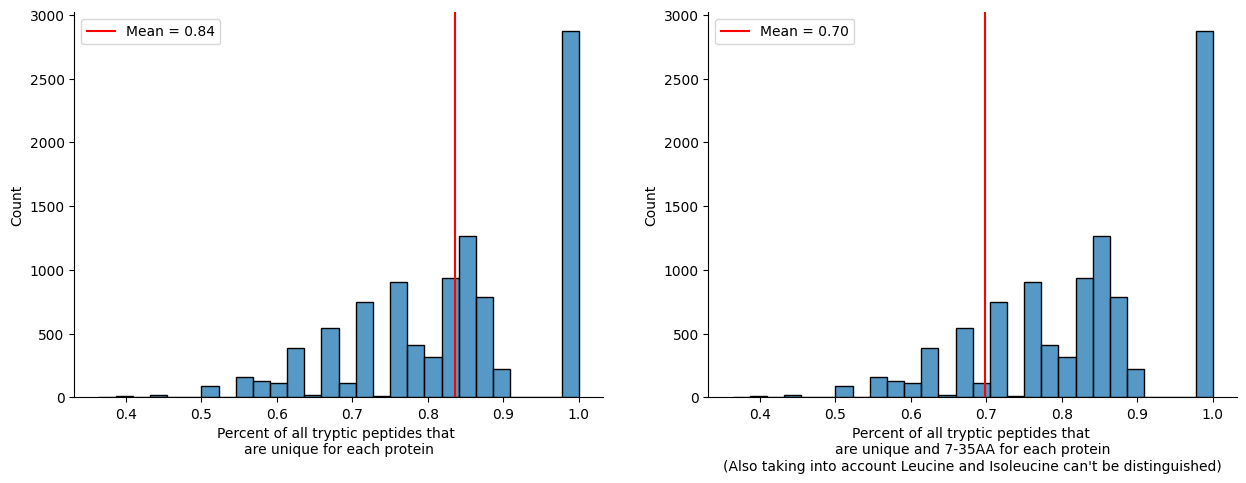

In [11]:

fig,axes = plt.subplots(nrows = 1, ncols =2, figsize = (15,5))
sns.histplot(x="perc_unique", data = Library, ax=axes[0])
axes[0].set_xlabel("Percent of all tryptic peptides that \nare unique for each protein")
sns.histplot(x="perc_unique", data = Library, ax=axes[1])
axes[0].axvline(Library["perc_unique"].mean(), color = "red", label =f'Mean = {Library["perc_unique"].mean():.2f}')
axes[0].legend()
axes[1].set_xlabel("Percent of all tryptic peptides that \nare unique and 7-35AA for each protein\n(Also taking into account Leucine and Isoleucine can't be distinguished)")
axes[1].axvline(Library["perc_unique_meetLenwIsomers"].mean(), color = "red", label =f'Mean = {Library["perc_unique_meetLenwIsomers"].mean():.2f}')
axes[1].legend()
sns.despine(top=True, right = True)

Text(0.5, 0, 'Number of unique predicted tryptic \npeptides (7-35 AA in length)\nper protein')

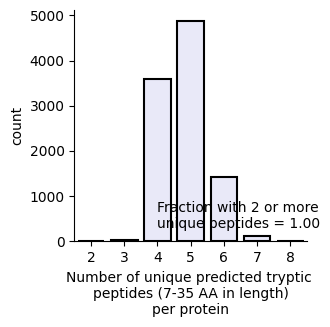

In [12]:
plt.figure(figsize=(3,3))
g=sns.countplot(x="NumUnique_meetLen_wIsomers",data = Library,color="lavender", edgecolor = "black", linewidth=1.5)
g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)
plt.text(2,300,f'Fraction with 2 or more\nunique peptides = {len(Library.query(""" NumUnique_meetLen_wIsomers > 1 """))/len(Library):.2f}')
plt.xlabel("Number of unique predicted tryptic \npeptides (7-35 AA in length)\nper protein")

## Generates a Dataframe where each line is a peptide

In [14]:
#Generates a dataframe where each row is a peptide
prot_name=[]
pep_seq=[]
pep_len=[]
prot_seq=[]
isunique = []
isunique_wIsomers = []

for i,r in Library.iterrows():
    for p in r["tryptic_peptides"]:
        isunique.append(p in r["UniquePeptides"])
        pep_seq.append(p)
        prot_name.append(r["name"])
        prot_seq.append(r["protein_sequence"])
        pep_len.append(len(p))
        isunique_wIsomers.append(p in r["UniquePeptides_wIsomers"])
     

Library_Peptides= pd.DataFrame(zip(pep_seq,prot_name,prot_seq, pep_len,isunique,isunique_wIsomers), columns=["PeptideSequence","ProteinName","ProteinSequence","PeptideLength","isUnique","isUnique_wIsomers"])

<Axes: xlabel='PeptideLength', ylabel='count'>

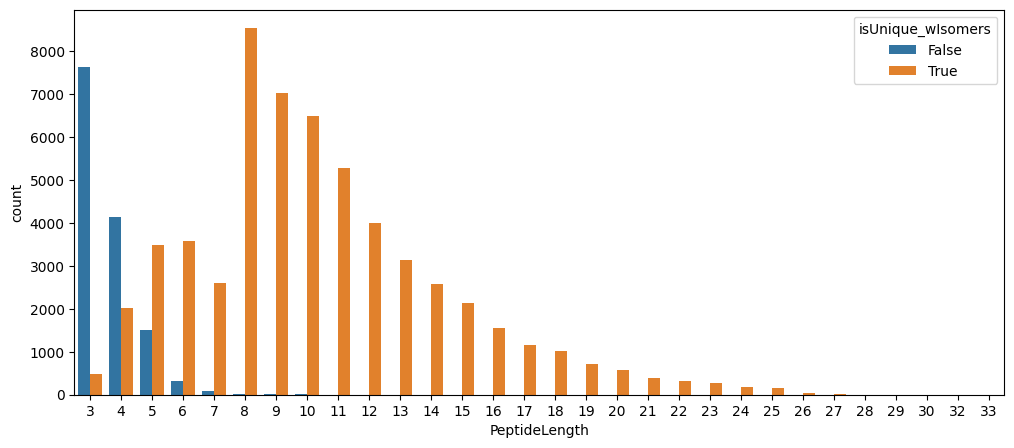

In [15]:
plt.figure(figsize=(12,5))
sns.countplot(x="PeptideLength", hue="isUnique_wIsomers", data = Library_Peptides)